In [13]:
import sys
import traceback

from dotenv import load_dotenv
from pathlib import Path
import os

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from lib import cliBot, getAIMessage

envPath =  Path().cwd().parent.joinpath("sample.env")
load_dotenv(dotenv_path=envPath, override=True)
memory = MemorySaver()
memConfig = {
    "configurable":{
        "thread_id":"1"
    }
}


In [14]:
def ad(num1: int, num2: int) -> int:
    """
    Add two numbers
    """
    return num1 + num2

def mul(num1: int, num2: int) -> int:
    """
    Multiplies two numbers
    :param num1:
    :param num2:
    :return: num
    """
    return num1 * num2


In [15]:
chat_model = os.getenv("GPT_MODEL")

llm = ChatOpenAI(model=chat_model)
toolsList = [ad, mul]
llm_with_tools = llm.bind_tools(tools=toolsList)

class BotState(MessagesState):
    pass

def agent(st: BotState):
    return {"messages":[llm_with_tools.invoke(st["messages"])]}



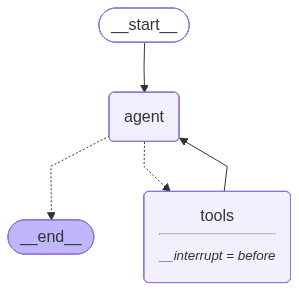

In [16]:
from IPython.core.display import Image

gr = StateGraph(BotState)

gr.add_node(agent)
# gr.add_node(agent2)
gr.add_node("tools", ToolNode(tools=toolsList))

gr.set_entry_point("agent")
gr.add_conditional_edges("agent", tools_condition)
gr.add_edge("tools", "agent")
# gr.add_edge("agent2", "agent")

g = gr.compile(interrupt_before=["tools"], checkpointer=MemorySaver())

display(Image(g.get_graph().draw_mermaid_png()))

In [31]:
msg1  = {"messages":[HumanMessage(content="multipy 3 and 9")]}
# msg2  = {"messages":[HumanMessage(content="")]}
# msg3  = {"messages":[HumanMessage(content="")]}

res = g.invoke(msg1, config = memConfig)


In [30]:
from lib import log_msg

try:
    cliBot(graphInstance=g, show_all_msg=False)
except KeyboardInterrupt as ki:
    log_msg("User interrupted the process")
except Exception as e:
    log_msg(str(e))
    traceback.print_exc(file=sys.stderr)

User interrupted the process


In [32]:
st = g.get_state(config=memConfig)
log_msg(st.next)

('tools',)


In [34]:
from lib import getAIMessage
res =g.invoke(None, config=memConfig)
getAIMessage(res)

'The product of 3 and 9 is 27.'

In [33]:
g.update_state( memConfig, {
    "input": "multiply 2,8 "
})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f110cf9-4429-6f7a-8013-6f985a0461d0'}}